In [3]:
#@title INSTALL NECESSARY PACKAGES
#Suppress output
!pip install tensorflow tensorflow-probability --quiet
!git clone https://github.com/honglu2875/weirdonetworks.git


import tensorflow as tf

%load_ext autoreload
%autoreload 2

git_folders = ["weirdonetworks"]

print("TensorFlow version {}".format(tf.__version__))

fatal: destination path 'weirdonetworks' already exists and is not an empty directory.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow version 2.7.0


In [5]:
#@title Mount working directories
import sys
import os

working_path = '/content/drive/MyDrive/Colab Notebooks'
lib_path = '/content/lib'
mod_path = '/content/mod'
data_path = '/content/data'

try:
  os.symlink(working_path+'/lib', lib_path)
except:
  print('Library folder already mounted!')
  pass
sys.path.insert(0,lib_path)
for f in git_folders:
    sys.path.insert(0, '/content/'+f)

try:
  os.symlink(working_path+'/SHARED_DATA/data', data_path)
except:
  print('Data folder already mounted!')
  pass

try:
  os.symlink(working_path+'/SHARED_DATA/mod', mod_path)
except:
  print('Model folder already mounted!')
  pass

In [99]:
#@title Import Libraries
import os 
import zipfile
import numpy as np # linear algebra
import itertools

from google.colab.patches import cv2_imshow # for image display
import cv2
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from weirdonetworks.nets.utils.eval import show_pic, ev_rotation_stability

ImportError: ignored

In [7]:
#@title Download data
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-12-26 16:30:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   118MB/s    in 0.6s    

2021-12-26 16:30:38 (118 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [53]:
#@title Unzip data and generate training and validation generators.

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

BATCH_SIZE = 20 #@param

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
train_datagen_unscaled = ImageDataGenerator(rescale = 1.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1./255. )
test_datagen_unscaled = ImageDataGenerator( rescale = 1. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = BATCH_SIZE, class_mode = 'binary', target_size = (224, 224))
train_generator_unscaled = train_datagen_unscaled.flow_from_directory(train_dir, batch_size = BATCH_SIZE, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = BATCH_SIZE, class_mode = 'binary', target_size = (224, 224))
validation_generator_unscaled = test_datagen_unscaled.flow_from_directory( validation_dir,  batch_size = BATCH_SIZE, class_mode = 'binary', target_size = (224, 224))


Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [57]:
#@title Download pretrained models (excluding top layers).

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.resnet50 import ResNet50

# base_models: list of tuples: (model, name, True/False), 3rd var indicating whether there is a rescaling layer or not
base_models = [
               (VGG16(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'), 'VGG16', False),
               (MobileNetV3Large(input_shape = (224, 224, 3), include_top = False, include_preprocessing = False, weights = 'imagenet'), 'MobileNetV3Large', False),
               (EfficientNetB7(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'), 'EfficientNetB7', True),
               (ResNet50(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'), 'ResNet50', True)]


In [58]:
#@title Train all models

models = []
hist = []

for bm,_,rescaling in base_models:
    for layer in bm.layers:
        layer.trainable = False

    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(bm.output)

    # Add a fully connected layer with 512 hidden units and ReLU activation
    x = layers.Dense(512, activation='relu')(x)

    # Add a dropout rate of 0.5
    x = layers.Dropout(0.5)(x)

    # Add a final sigmoid layer with 1 node for classification output (use sigmoid because we have only 2 classes)
    x = layers.Dense(1, activation='sigmoid')(x)

    # Combine the pretrained layers with the dense layer to form our model for transfer learning
    models.append( tf.keras.models.Model(bm.input, x) )
    models[-1].compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

    # Train (gonna take a while...)
    if rescaling:
        g = train_generator_unscaled
        vg = validation_generator_unscaled
    else:
        g = train_generator
        vg = validation_generator
    hist.append( models[-1].fit(g, validation_data = vg, steps_per_epoch = 100, epochs = 2) )

Epoch 1/2
100/100 [==============================] - 46s 451ms/step - loss: 0.5385 - acc: 0.7310 - val_loss: 0.2804 - val_acc: 0.8780
Epoch 2/2
100/100 [==============================] - 45s 447ms/step - loss: 0.4176 - acc: 0.8105 - val_loss: 0.2382 - val_acc: 0.9010
Epoch 1/2
100/100 [==============================] - 39s 347ms/step - loss: 0.2593 - acc: 0.8895 - val_loss: 0.0811 - val_acc: 0.9820
Epoch 2/2
100/100 [==============================] - 34s 337ms/step - loss: 0.1053 - acc: 0.9620 - val_loss: 0.0526 - val_acc: 0.9840
Epoch 1/2
100/100 [==============================] - 108s 838ms/step - loss: 0.2102 - acc: 0.9470 - val_loss: 0.8459 - val_acc: 0.5000
Epoch 2/2
100/100 [==============================] - 80s 805ms/step - loss: 0.1957 - acc: 0.9665 - val_loss: 3.6656 - val_acc: 0.5000
Epoch 1/2
100/100 [==============================] - 51s 468ms/step - loss: 0.8707 - acc: 0.8905 - val_loss: 4.1191 - val_acc: 0.5000
Epoch 2/2
100/100 [==============================] - 49s 492m

# Test the transformation stability under transfer-learning using pre-trained models

Here we propose two metric to describe the stability of a model under a transformation.

---
## Notation setup
In our small scale setup, we assume that in the last layer we use sigmoid to classify binary classes. Also assume the input space is n-dimensional.

- $F: R^n\rightarrow R^n$ a piecewise-linear function according to a trained model. 

- $S=\{s: R^n\rightarrow R^n\}$ the (topological) space (most often manifolds) of transformations (endomorphisms) that we want to apply. In this notebook, we sample the rotations. It is NOT closed under compositions! For example, rotating turns some pixels out of bound and a further rotation forces us to fill in boundary values. 

- Assume $S$ is compact and has volume $1$ ($\int_Sds=1$).

Remark (vent?):
1. In the literature, people open say that $S$ forms a group and cite the group axioms. In a lot of scenarios outside of computer vision, this is indeed suitable. But when we talk about transformations on "images", the whole math falls apart:
    - Because 1. images are usually represented in a rectangular frame and 2. images are pixelated, the image transformations almost never form a group!
    - Without group axioms we might still have a monoid action, but even the "action" part falls apart: $$f\circ g(x) \neq (f\circ g)(x), \qquad f,g\in S$$

Is it "almost" a group action? No, not even close. Gladly, most papers involving image transforms do not essentially use the group action on functions, therefore not much is invalidated. This is simply a very dangerous practise that's worth being pointed out.

---
## Transformation variance
Fix an input $x\in S$, we define the transformation variance as follows:
$$ v=\int_S \left((f\circ s')(x)-\int_S(f\circ s)(x)ds\right)^2 ds' $$
When $S$ is discrete with normalized discrete measure (evaluate to $1/|S|$ on every point), this is literally the variance of the set.

This has a direct meaning: when we transform the image, the predicted probability should fluctuate as little as possible. It has its limit: it does not take how violence the fluctuation is into consideration. This is reflected the most in the example when the rotation of an image {\bf should} yield a different answer (e.g., recognizing 6 and 9 in MNIST). Such information is encoded in the derivatives under transformations.

## Transformation difference
Fix an input $x\in S$, assume $S$ forms a Riemannian manifold (locally Euclidean with a compatible measure induced by the metric), we define the transformation difference as follows:
$$d=\int_S\|\nabla_s(f\circ s)\|_nds,$$
where the gradient is taken over $s\in S$ and $\|\cdot\|_n$ is the $\mathcal l_n$-norm. In this notebook, $\mathcal l_1$-norm is used. This measures how fierce the fluctuation of value it is when we transform the image through $S$.

Note that this definition does not generalize to discrete sets to automatically include a discrete version. But an approximate version of the gradient and the integral is easy to formulate.

In [172]:
#@title Test on validation data without transformations
MAX_IMG = 100 #@param

for md,bm in zip(models, base_models):
    _,name,rescaling = bm

    vg = validation_generator_unscaled if rescaling else validation_generator

    img_count, count = 0, 0
    for x,y in vg:

        y_pred = np.reshape(md.predict(x), -1) # flatten the output
        count += np.sum((y>0.5) == (y_pred>0.5))

        img_count += BATCH_SIZE
        if img_count >= MAX_IMG: break

    print(name + ": " + str(count/img_count))

VGG16: 0.91
MobileNetV3Large: 0.98
EfficientNetB7: 0.98
ResNet50: 0.98


In [190]:
#from weirdonetworks.nets.utils.eval import ev_rotation_stability
var = []
dif = []
pred = []
tar = []
for md,bm in zip(models, base_models):
    _,name,rescaling = bm

    v, d, p, y = ev_rotation_stability(md, test_generator, MAX_IMG=100, NEED_RESCALING=rescaling)
    var.append(v)
    dif.append(d)
    pred.append(p)
    tar.append(y)

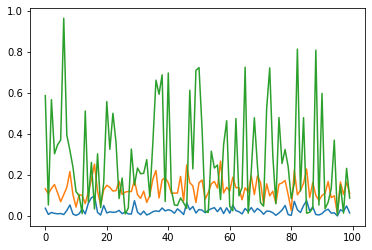

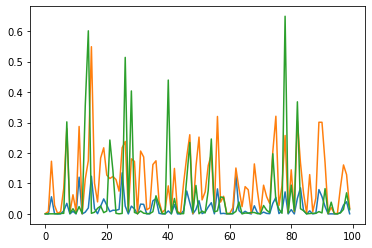

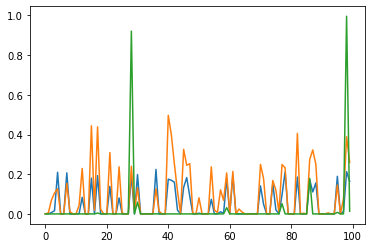

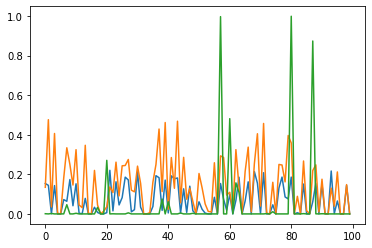

In [191]:
for i in range(len(var)):
    plt.plot(var[i])
    plt.plot(dif[i])
    plt.plot(abs(pred[i][0,:]-tar[i]))
    plt.show()